# Late Fusion by Reaction Time Groups (PRE Features, Weighted Fusion)

This notebook splits trials into reaction time groups (fast vs slow) and runs late fusion for each group.


In [3]:
import pickle
import json
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score, f1_score
from sklearn.impute import SimpleImputer
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
sns.set_style('whitegrid')


## 1. Load Pre-Extracted Features


In [4]:
# Load pre-extracted features
with open('../../data/results/features_PRE/extracted_features_PRE.pkl', 'rb') as f:
    feature_data = pickle.load(f)

merged_df = feature_data['merged_df']
physio_cols = feature_data['physio_cols']
behavior_cols = feature_data['behavior_cols']
gaze_cols = feature_data['gaze_cols']

print(f"✓ Loaded {len(merged_df)} trials from {merged_df['subject_id'].nunique()} subjects")
print(f"  Features extracted on: {feature_data['metadata']['extraction_date']}")
print(f"\nReaction time stats:")
print(f"  Mean: {merged_df['reaction_time'].mean():.2f}s")
print(f"  Median: {merged_df['reaction_time'].median():.2f}s")
print(f"  Min: {merged_df['reaction_time'].min():.2f}s")
print(f"  Max: {merged_df['reaction_time'].max():.2f}s")


def weighted_late_fusion(X_modalities, y, subjects, modality_names):
    """
    Weighted late fusion using logistic regression meta-learner.
    Returns subject-level accuracy for proper SEM calculation.
    """
    logo = LeaveOneGroupOut()
    base_models = [RandomForestClassifier(n_estimators=100, max_depth=5, 
                                          min_samples_split=10, min_samples_leaf=5, 
                                          random_state=42,
                                          class_weight='balanced')
                   for _ in X_modalities]
    
    # Store subject-level results
    subject_accs = {}
    subject_f1s = {}
    all_weights = []
    
    for train_idx, test_idx in logo.split(X_modalities[0], y, subjects):
        train_probs, test_probs = [], []
        
        for X, model in zip(X_modalities, base_models):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train = y[train_idx]
            
            model.fit(X_train, y_train)
            train_probs.append(model.predict_proba(X_train)[:, 1])
            test_probs.append(model.predict_proba(X_test)[:, 1])
        
        train_probs = np.column_stack(train_probs)
        test_probs = np.column_stack(test_probs)
        y_train, y_test = y[train_idx], y[test_idx]
        
        meta = LogisticRegression(random_state=42, max_iter=1000)
        meta.fit(train_probs, y_train)
        weights = meta.coef_[0]
        y_pred = meta.predict(test_probs)
        
        # Store subject-level metrics
        test_subject = subjects[test_idx][0]
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        subject_accs[test_subject] = acc
        subject_f1s[test_subject] = f1
        all_weights.append(weights)
    
    # Convert to arrays
    subject_acc_values = np.array(list(subject_accs.values()))
    subject_f1_values = np.array(list(subject_f1s.values()))
    
    avg_weights = np.mean(all_weights, axis=0)
    norm_weights = np.exp(avg_weights) / np.sum(np.exp(avg_weights))
    
    return {
        'accuracy_mean': np.mean(subject_acc_values),
        'accuracy_sem': stats.sem(subject_acc_values),
        'accuracy_std': np.std(subject_acc_values),
        'accuracy_per_subject': subject_acc_values,
        'f1_mean': np.mean(subject_f1_values),
        'f1_sem': stats.sem(subject_f1_values),
        'f1_std': np.std(subject_f1_values),
        'f1_per_subject': subject_f1_values,
        'weights': norm_weights,
        'n_trials': len(y),
        'n_subjects': len(subject_accs),
    }


✓ Loaded 12511 trials from 97 subjects
  Features extracted on: 2025-12-27 14:10:40

Reaction time stats:
  Mean: 1.59s
  Median: 1.41s
  Min: 0.14s
  Max: 4.58s


## 2. Create Reaction Time Groups


In [5]:
# Create reaction time groups using median split
rt_median = merged_df['reaction_time'].median()
merged_df['rt_group'] = merged_df['reaction_time'].apply(lambda x: 'Fast' if x <= rt_median else 'Slow')

print(f"\nMedian reaction time: {rt_median:.2f}s")
print("\nReaction time group distribution:")
print(merged_df['rt_group'].value_counts())

for group in ['Fast', 'Slow']:
    group_data = merged_df[merged_df['rt_group'] == group]
    print(f"\n{group} group:")
    print(f"  RT range: {group_data['reaction_time'].min():.2f}s - {group_data['reaction_time'].max():.2f}s")
    print(f"  RT mean: {group_data['reaction_time'].mean():.2f}s")



Median reaction time: 1.41s

Reaction time group distribution:
rt_group
Fast    6256
Slow    6255
Name: count, dtype: int64

Fast group:
  RT range: 0.14s - 1.41s
  RT mean: 1.03s

Slow group:
  RT range: 1.41s - 4.58s
  RT mean: 2.15s


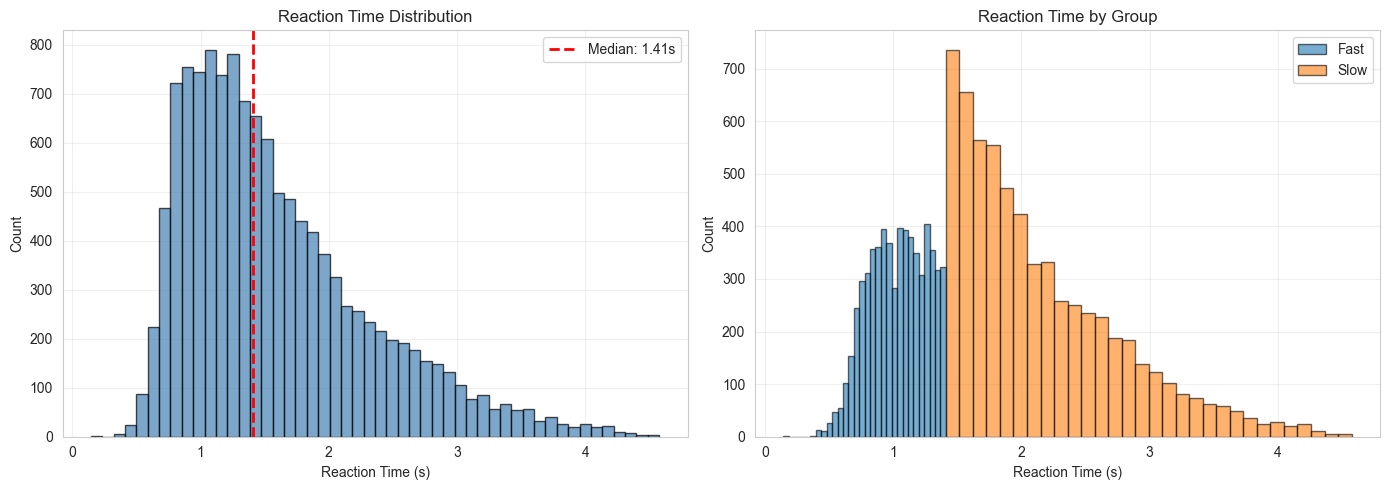

In [6]:
# Visualize RT distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.hist(merged_df['reaction_time'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
ax.axvline(rt_median, color='red', linestyle='--', linewidth=2, label=f'Median: {rt_median:.2f}s')
ax.set_xlabel('Reaction Time (s)')
ax.set_ylabel('Count')
ax.set_title('Reaction Time Distribution')
ax.legend()
ax.grid(alpha=0.3)

ax = axes[1]
for group in ['Fast', 'Slow']:
    group_data = merged_df[merged_df['rt_group'] == group]
    ax.hist(group_data['reaction_time'], bins=30, alpha=0.6, label=group, edgecolor='black')
ax.set_xlabel('Reaction Time (s)')
ax.set_ylabel('Count')
ax.set_title('Reaction Time by Group')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [7]:
physio_cols = [c for c in merged_df.columns if c.endswith('_pre')]
# Exclude reaction_time from behavior features since we're grouping by it
behavior_cols = ['decision_time', 'ev_difference', 
                 'invest_variance', 'ambiguity', 'condition_social', 'risk_premium']
gaze_cols = [c for c in merged_df.columns 
             if c.startswith('gaze_') or c.startswith('screen_') or 
             c in ['fixation_ratio', 'saccade_ratio', 'saccade_count', 'gaze_valid_pct',
                   'gaze_dispersion_x', 'gaze_dispersion_y', 'gaze_path_length']]

print(f"Physiology (PRE): {len(physio_cols)} features")
print(f"Behavior: {len(behavior_cols)} features")
print(f"Gaze: {len(gaze_cols)} features")


Physiology (PRE): 13 features
Behavior: 6 features
Gaze: 20 features


## 3. Run Late Fusion for Each RT Group


In [8]:
modality_names = ['Physiology (PRE)', 'Behavior', 'Gaze']
group_results = {}

for group in ['Fast', 'Slow']:
    print(f"\n{'='*80}")
    print(f"Reaction Time Group: {group}")
    print(f"{'='*80}")
    
    group_data = merged_df[merged_df['rt_group'] == group]
    
    n_subjects = group_data['subject_id'].nunique()
    print(f"Trials: {len(group_data)}")
    print(f"Subjects: {n_subjects}")
    print(f"Outcome distribution: {group_data['outcome'].value_counts().to_dict()}")
    print(f"RT range: {group_data['reaction_time'].min():.2f}s - {group_data['reaction_time'].max():.2f}s")
    
    X_physio = SimpleImputer(strategy='mean').fit_transform(group_data[physio_cols])
    X_behavior = SimpleImputer(strategy='mean').fit_transform(group_data[behavior_cols])
    X_gaze = SimpleImputer(strategy='mean').fit_transform(group_data[gaze_cols])
    y = group_data['outcome'].values
    subjects = group_data['subject_id'].values
    
    X_modalities = [X_physio, X_behavior, X_gaze]
    
    results = weighted_late_fusion(X_modalities, y, subjects, modality_names)
    group_results[group] = results
    
    print(f"\nResults:")
    print(f"  Accuracy: {results['accuracy_mean']:.3f} ± {results['accuracy_sem']:.3f} (SEM) / ± {results['accuracy_std']:.3f} (SD)")
    print(f"  F1-Score: {results['f1_mean']:.3f} ± {results['f1_sem']:.3f} (SEM)")
    print(f"\n  Modality Weights:")
    for name, w in zip(modality_names, results['weights']):
        print(f"    {name}: {w:.3f}")



Reaction Time Group: Fast
Trials: 6256
Subjects: 97
Outcome distribution: {1: 4573, 0: 1683}
RT range: 0.14s - 1.41s

Results:
  Accuracy: 0.707 ± 0.019 (SEM) / ± 0.190 (SD)
  F1-Score: 0.711 ± 0.021 (SEM)

  Modality Weights:
    Physiology (PRE): 0.019
    Behavior: 0.011
    Gaze: 0.970

Reaction Time Group: Slow
Trials: 6255
Subjects: 97
Outcome distribution: {1: 3665, 0: 2590}
RT range: 1.41s - 4.58s

Results:
  Accuracy: 0.624 ± 0.013 (SEM) / ± 0.130 (SD)
  F1-Score: 0.614 ± 0.015 (SEM)

  Modality Weights:
    Physiology (PRE): 0.016
    Behavior: 0.000
    Gaze: 0.983


## 4. Compare Results Across Groups


In [9]:
comparison_df = pd.DataFrame([
    {
        'Group': group,
        'N_Trials': results['n_trials'],
        'N_Subjects': results['n_subjects'],
        'Accuracy': results['accuracy_mean'],
        'Accuracy_SEM': results['accuracy_sem'],
        'Accuracy_SD': results['accuracy_std'],
        'F1-Score': results['f1_mean'],
        'F1_SEM': results['f1_sem'],
        'Physiology_Weight': results['weights'][0],
        'Behavior_Weight': results['weights'][1],
        'Gaze_Weight': results['weights'][2]
    }
    for group, results in group_results.items()
])

print("\n" + "="*80)
print("COMPARISON ACROSS REACTION TIME GROUPS (with SEM)")
print("="*80)
print(comparison_df[['Group', 'N_Trials', 'N_Subjects', 'Accuracy', 'Accuracy_SEM', 'Accuracy_SD']].to_string(index=False))

print("\n" + "="*80)
print("NOTE: Error bars use SEM (Standard Error of Mean) from subject-level accuracies")
print("WARNING: Subjects are NOT equally represented in each RT group!")
print("="*80)



COMPARISON ACROSS REACTION TIME GROUPS (with SEM)
Group  N_Trials  N_Subjects  Accuracy  Accuracy_SEM  Accuracy_SD
 Fast      6256          97  0.707405      0.019430     0.190372
 Slow      6255          97  0.624387      0.013297     0.130285

NOTE: Error bars use SEM (Standard Error of Mean) from subject-level accuracies


## 5. Visualizations


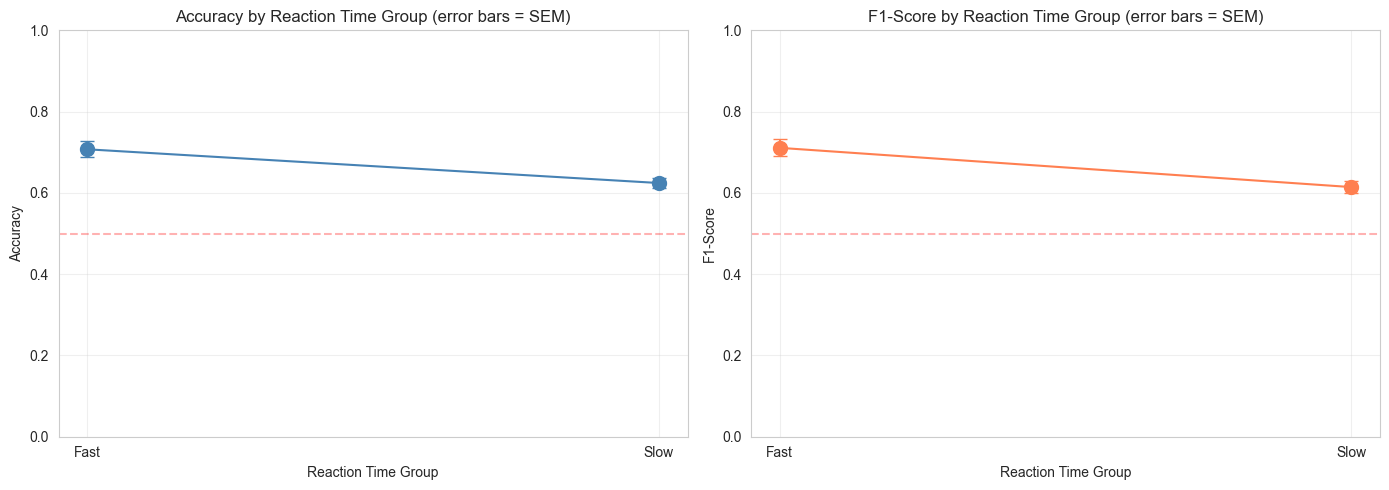

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
ax = axes[0]
ax.errorbar(comparison_df['Group'], comparison_df['Accuracy'], 
            yerr=comparison_df['Accuracy_SEM'], fmt='o-', capsize=5, color='steelblue', markersize=10)
ax.set_xlabel('Reaction Time Group')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by Reaction Time Group (error bars = SEM)')
ax.set_ylim([0, 1])
ax.axhline(0.5, color='red', linestyle='--', alpha=0.3)
ax.grid(alpha=0.3)

# F1-Score
ax = axes[1]
ax.errorbar(comparison_df['Group'], comparison_df['F1-Score'], 
            yerr=comparison_df['F1_SEM'], fmt='o-', capsize=5, color='coral', markersize=10)
ax.set_xlabel('Reaction Time Group')
ax.set_ylabel('F1-Score')
ax.set_title('F1-Score by Reaction Time Group (error bars = SEM)')
ax.set_ylim([0, 1])
ax.axhline(0.5, color='red', linestyle='--', alpha=0.3)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


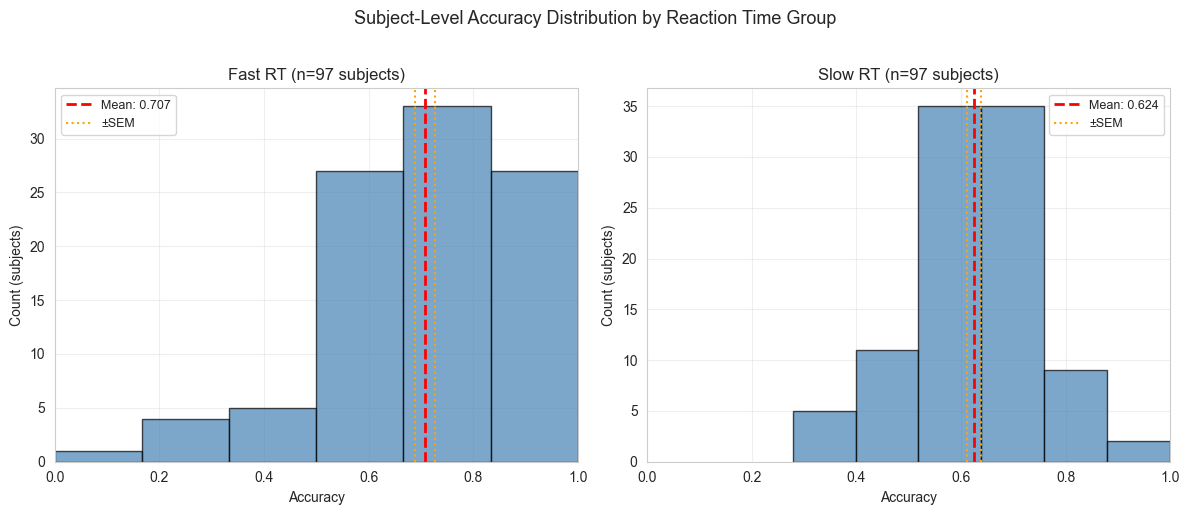

In [11]:
# Plot subject-level accuracy distributions for each RT group
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for idx, (group, results) in enumerate(group_results.items()):
    ax = axes[idx]
    subject_accs = results['accuracy_per_subject']
    
    # Histogram
    ax.hist(subject_accs, bins=6, color='steelblue', alpha=0.7, edgecolor='black')
    ax.axvline(results['accuracy_mean'], color='red', linestyle='--', linewidth=2,
               label=f"Mean: {results['accuracy_mean']:.3f}")
    ax.axvline(results['accuracy_mean'] - results['accuracy_sem'], color='orange',
               linestyle=':', linewidth=1.5, label=f"±SEM")
    ax.axvline(results['accuracy_mean'] + results['accuracy_sem'], color='orange',
               linestyle=':', linewidth=1.5)
    
    ax.set_xlabel('Accuracy')
    ax.set_ylabel('Count (subjects)')
    ax.set_title(f'{group} RT (n={results["n_subjects"]} subjects)')
    ax.set_xlim([0, 1])
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)

plt.suptitle('Subject-Level Accuracy Distribution by Reaction Time Group', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()


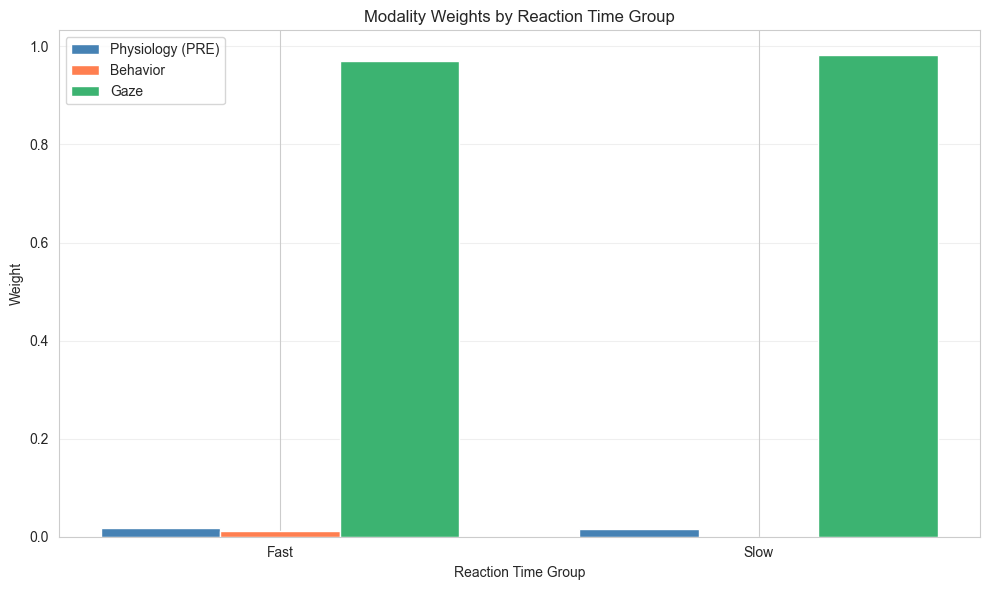

In [12]:
# Modality weights by group
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(comparison_df))
width = 0.25

ax.bar(x - width, comparison_df['Physiology_Weight'], width, 
       label='Physiology (PRE)', color='steelblue')
ax.bar(x, comparison_df['Behavior_Weight'], width, 
       label='Behavior', color='coral')
ax.bar(x + width, comparison_df['Gaze_Weight'], width, 
       label='Gaze', color='mediumseagreen')

ax.set_xlabel('Reaction Time Group')
ax.set_ylabel('Weight')
ax.set_title('Modality Weights by Reaction Time Group')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Group'])
ax.legend()
ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()
